# Gradient Descent Optimizations

Mini-batch and stochastic gradient descent is widely used in deep learning, where the large number of parameters and  limited memory make the use of more sophisticated optimization methods impractical. Many methods have been proposed to accelerate gradient descent in this context, and here we sketch the ideas behind some of the most popular algorithms.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Smoothing with exponentially weighted averages

In [3]:
n = 50
x = np.arange(n) * np.pi
y = np.cos(x) * np.exp(x/100) - 10*np.exp(-0.01*x)

### Exponentially weighted average

The exponentially weighted average adds a fraction $\beta$ of the current value to a leaky running sum of past values. Effectively, the contribution from the $t-n$th value is scaled by

$$
\beta^n(1 - \beta)
$$

For example, here are the contributions to the current value after 5 iterations (iteration 5 is the current iteration)

| iteration | contribution |
| --- | --- |
| 1 | $\beta^4(1 - \beta)$ |
| 2 | $\beta^3(1 - \beta)$ |
| 3 | $\beta^2(1 - \beta)$ |
| 4 | $\beta^1(1 - \beta)$ |
| 5 | $(1 - \beta)$ |

Since $\beta \lt 1$, the contribution decreases exponentially with the passage of time. Effectively, this acts as a smoother for a function.

In [4]:
def ewa(y, beta):
    """Exponentially weighted average."""
    
    n = len(y)
    zs = np.zeros(n)
    z = 0
    for i in range(n):
        z = beta*z + (1 - beta)*y[i]
        zs[i] = z
    return zs

### Exponentially weighted average with bias correction

Since the EWA starts from 0, there is an initial bias. This can be corrected by scaling with 

$$
\frac{1}{1 - \beta^t}
$$

where $t$ is the iteration number.

In [5]:
def ewabc(y, beta):
    """Exponentially weighted average with hias correction."""
    
    n = len(y)
    zs = np.zeros(n)
    z = 0
    for i in range(n):
        z = beta*z + (1 - beta)*y[i]
        zc = z/(1 - beta**(i+1))
        zs[i] = zc
    return zs

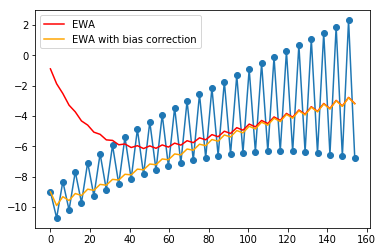

In [6]:
beta = 0.9

plt.plot(x, y, 'o-')
plt.plot(x, ewa(y, beta), c='red', label='EWA')
plt.plot(x, ewabc(y, beta), c='orange', label='EWA with bias correction')
plt.legend()
pass

## Momentum in 1D

Momentum comes from physics, where the contribution of the gradient is to the velocity, not the position. Hence we create an accessory variable $v$ and increment it with the gradient. The position is then updated with the velocity in place of the gradient. The analogy is that we can think of the parameter $x$ as a particle in an energy well with potential energy $U = mgh$ where $h$ is given by our objective function $f$. The force generated is a function of the rat of change of potential energy $F \propto \nabla U \propto \nabla f$, and we use $F = ma$ to get that the acceleration $a \propto \nabla f$. Finally, we integrate $a$ over time to get the velocity $v$ and integrate $v$ to get the displacement $x$. Note that we need to damp the velocity otherwise the particle would just oscillate forever.

We use a version of the update that simply treats the velocity as an exponentially weighted average popularized by Andrew Ng in his Coursera course. This is the same as the momentum scheme motivated by physics with some rescaling of constants.

In [7]:
def f(x):
    return x**2

In [8]:
def grad(x):
    return 2*x

In [9]:
def gd(x, grad, alpha, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    for i in range(max_iter):
        x = x - alpha * grad(x)
        xs[i+1] = x
    return xs

In [10]:
def gd_momentum(x, grad, alpha, beta=0.9, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x)
        vc = v/(1+beta**(i+1))
        x = x - alpha * vc
        xs[i+1] = x
    return xs

### Gradient descent with moderate step size

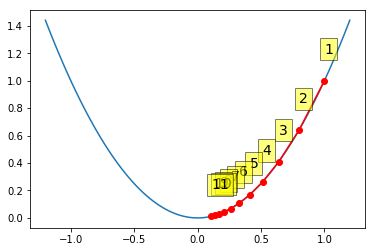

In [11]:
alpha = 0.1
x0 = 1
xs = gd(x0, grad, alpha)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i, 
             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
pass

### Gradient descent with large step size

When the step size is too large, gradient descent can oscillate and even diverge.

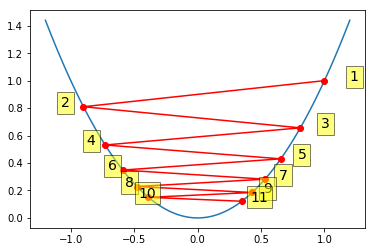

In [12]:
alpha = 0.95
xs = gd(1, grad, alpha)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x*1.2, y, i,
             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
pass

### Gradient descent with momentum

Momentum results in cancellation of gradient changes in opposite directions, and hence damps out oscillations while amplifying consistent changes in the same direction. This is perhaps clearer in the 2D example below.

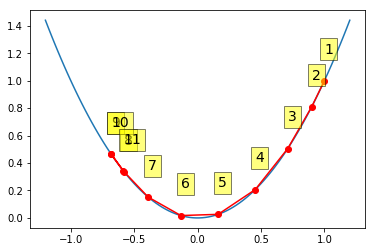

In [13]:
alpha = 0.95
xs = gd_momentum(1, grad, alpha, beta=0.9)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i, 
             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
pass

## Momentum and RMSprop in 2D

In [14]:
def f2(x):
    return x[0]**2 + 100*x[1]**2

In [15]:
def grad2(x):
    return np.array([2*x[0], 200*x[1]])

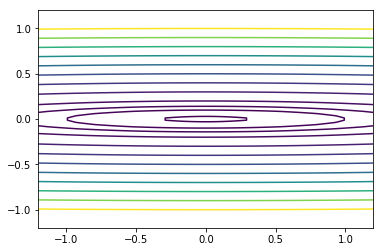

In [16]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
pass

In [17]:
def gd2(x, grad, alpha, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0,:] = x
    for i in range(max_iter):
        x = x - alpha * grad(x)
        xs[i+1,:] = x
    return xs

In [18]:
def gd2_momentum(x, grad, alpha, beta=0.9, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0, :] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x)
        vc = v/(1+beta**(i+1))
        x = x - alpha * vc
        xs[i+1, :] = x
    return xs

### Gradient descent with large step size

We get severe oscillations.

In [19]:
alpha = 0.01
x0 = np.array([-1,-1])
xs = gd2(x0, grad2, alpha, max_iter=75)

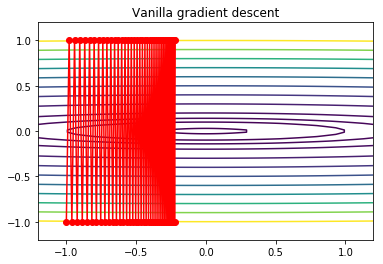

In [20]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Vanilla gradient descent')
pass

### Gradient descent with momentum

The damping effect is clear.

In [21]:
alpha = 0.01
x0 = np.array([-1,-1])
xs = gd2_momentum(x0, grad2, alpha, beta=0.9, max_iter=75)

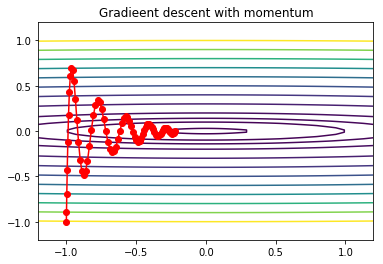

In [22]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Gradieent descent with momentum')
pass

### Gradient descent with RMSprop

RMSprop scales the learning rate in each direction by the square root of the exponentially weighted sum of squared gradients. Near a saddle or any plateau, there are directions where the gradient is very small - RMSporp encourages larger steps in those directions, allowing faster escape.

In [23]:
def gd2_rmsprop(x, grad, alpha, beta=0.9, eps=1e-8, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0, :] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x)**2
        x = x - alpha * grad(x) / (eps + np.sqrt(v))
        xs[i+1, :] = x
    return xs

In [24]:
alpha = 0.1
x0 = np.array([-1,-1])
xs = gd2_rmsprop(x0, grad2, alpha, beta=0.9, max_iter=10)

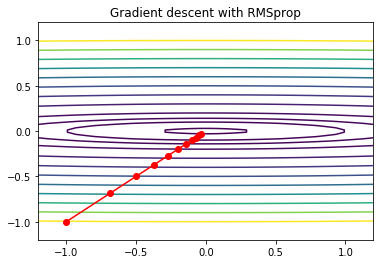

In [25]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Gradient descent with RMSprop')
pass

### ADAM

ADAM (Adaptive Moment Estimation) combines the ideas of momentum, RMSprop and bias correction. It is probably the most popular gradient descent method in current deep learning practice.

In [26]:
def gd2_adam(x, grad, alpha, beta1=0.9, beta2=0.999, eps=1e-8, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0, :] = x
    m = 0
    v = 0
    for i in range(max_iter):
        m = beta1*m + (1-beta1)*grad(x)
        v = beta2*v + (1-beta2)*grad(x)**2
        mc = m/(1+beta1**(i+1))
        vc = v/(1+beta2**(i+1))
        x = x - alpha * m / (eps + np.sqrt(vc))
        xs[i+1, :] = x
    return xs

In [27]:
alpha = 0.1
x0 = np.array([-1,-1])
xs = gd2_adam(x0, grad2, alpha, beta1=0.9, beta2=0.9, max_iter=10)

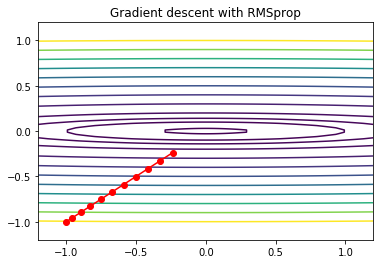

In [28]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Gradient descent with RMSprop')
pass

## Implementing a custom optimization routine for `scipy.optimize`

Gradient descent is not one of the methods available in `scipy.optimize`. However we can implement our own version by following the API of the `minimize` function.

In [29]:
import scipy.optimize as opt
import scipy.linalg as la

In [30]:
def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the Rosen function."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * rosen_der(bestx)
        bestx = bestx - step

        bestf = fun(bestx)
        funcalls += 1
        
        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,
                              nfev=funcalls, success=(niter > 1))

In [31]:
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

### Test on Rosenbrock banana function

We will use the [Rosenbrock "banana" function](http://en.wikipedia.org/wiki/Rosenbrock_function) to illustrate unconstrained multivariate optimization. In 2D, this is
$$
f(x, y) = b(y - x^2)^2 + (a - x)^2
$$

The function has a global minimum at (1,1) and the standard expression takes $a = 1$ and $b = 100$. 

#### Conditioning of optimization problem

With these values for $a$ and $b$, the problem is ill-conditioned. As we shall see, one of the factors affecting the ease of optimization is the condition number of the curvature (Hessian). When the condition number is high, the gradient may not point in the direction of the minimum, and simple gradient descent methods may be inefficient since they may be forced to take many sharp turns.

For the 2D version, we have

$$
f(x) = 100(y - x^2)^2 + (1 - x)^2
$$

and can calculate the Hessian to be 

$$
\begin{bmatrix}
802 & -400 \\
-400 & 200
\end{bmatrix}
$$

In [32]:
H = np.array([
    [802, -400],
    [-400, 200]
])

In [33]:
np.linalg.cond(H)

2508.009601277298

In [34]:
U, s, Vt = np.linalg.svd(H)
s[0]/s[1]

2508.0096012772983

#### Function to minimize

In [35]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0)

In [36]:
def rosen_der(x):
    """Derivative of generalized Rosen function."""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

#### Why is the condition number so large?

In [37]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

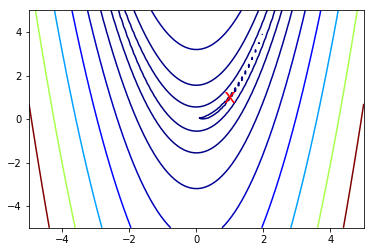

In [38]:
# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20)
pass

#### Zooming in to the global minimum at (1,1)

In [39]:
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

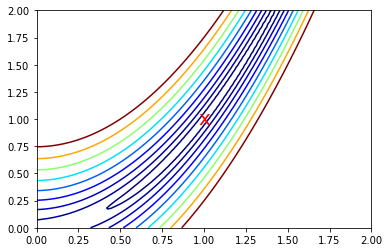

In [40]:
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 1.5, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20)
pass

#### We will use our custom gradient descent to minimize the banana function

#### Helpful Hint 

One of the most common causes of failure of optimization is because the gradient  or Hessian function is specified incorrectly. You can check for this using `check_grad` which compares the analytical gradient with one calculated using finite differences.

In [41]:
from scipy.optimize import check_grad

for x in np.random.uniform(-2,2,(10,2)):
    print(x, check_grad(rosen, rosen_der, x))

[ 1.48907302 -1.42171331] 3.04092560512107e-05
[-0.48887404  1.21108406] 1.0685858595103707e-06
[-1.1971752   1.28731448] 9.014975946452588e-06
[-0.74543228  0.77030133] 3.1276750146010007e-06
[ 0.24111646 -1.65737227] 7.678560202206516e-06
[-1.37253259 -1.06738594] 2.2075707844094206e-05
[-0.16354856  0.61330733] 2.526511024327562e-06
[-1.20574923  0.20626545] 1.3748984984515249e-05
[ 1.73282778 -1.84865849] 3.4902945985726736e-05
[ 0.4104856  -1.81645528] 4.023697388337955e-06


In [42]:
# Initial starting position
x0 = np.array([4,-4.1])
ps = [x0]
opt.minimize(rosen, x0, method=custmin, callback=reporter)

     fun: 1.060466347344834e-08
    nfev: 100001
     nit: 100000
 success: True
       x: array([0.9998971 , 0.99979381])

In [43]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

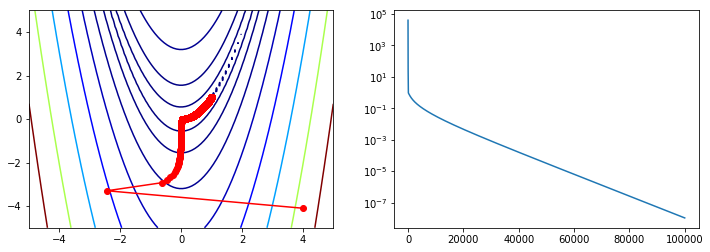

In [44]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T))
pass

### Comparison with standard algorithms

Note that all these methods take far fewer function iterations and function evaluations to find the minimum compared with vanilla gradient descent.

Many of these are based on estimating the Newton direction. Recall Newton's method for finding roots of a univariate function

$$
x_{K+1} = x_k - \frac{f(x_k)}{f'(x_k)}
$$

When we are looking for a minimum, we are looking for the roots of the *derivative* $f'(x)$, so

$$
x_{K+1} = x_k - \frac{f'(x_k}{f''(x_k)}
$$

Newton's method can also be seen as a Taylor series approximation

$$
f(x+h) = f(x) + h f'(x) + \frac{h^2}{2}f''(x)
$$

At the function minimum, the derivative is 0, so
\begin{align}
\frac{f(x+h) - f(x)}{h} &= f'(x) + \frac{h}{2}f''(x) \\
0 &= f'(x) + \frac{h}{2}f''(x) 
\end{align}

and letting $\Delta x = \frac{h}{2}$, we get that the Newton step is

$$
\Delta x = - \frac{f'(x)}{f''(x)}
$$

The multivariate analog replaces $f'$ with the Jacobian and $f''$ with the Hessian, so the Newton step is

$$
\Delta x = -H^{-1}(x) \nabla f(x)
$$

Slightly more rigorously, we can optimize the quadratic multivariate Taylor expansion 

$$
f(x + p) = f(x) + p^T\nabla f(x) + \frac{1}{2}p^TH(x)p
$$

Differentiating with respect to the direction vector $p$ and setting to zero, we get

$$
H(x)p = -\nabla f(x)
$$

giving

$$
p = -H(x)^{-1}\nabla f(x)
$$

In [45]:
from scipy.optimize import rosen, rosen_der, rosen_hess

#### Nelder-Mead

There are some optimization algorithms not based on the Newton method, but on other heuristic search strategies that do not require any derivatives, only function evaluations. One well-known example is the Nelder-Mead simplex algorithm.

In [46]:
ps = [x0]
opt.minimize(rosen, x0, method='nelder-mead', callback=reporter)

 final_simplex: (array([[0.99998846, 0.99997494],
       [0.99994401, 0.99989075],
       [1.0000023 , 1.0000149 ]]), array([5.26275688e-10, 3.87529507e-09, 1.06085894e-08]))
           fun: 5.262756878429089e-10
       message: 'Optimization terminated successfully.'
          nfev: 162
           nit: 85
        status: 0
       success: True
             x: array([0.99998846, 0.99997494])

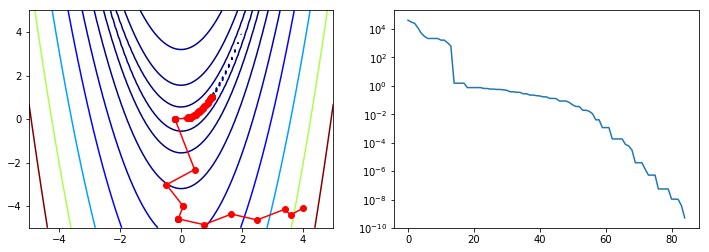

In [47]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### BFGS

As calculating the Hessian is computationally expensive, sometimes first order methods that only use the first derivatives are preferred. Quasi-Newton methods use functions of the first derivatives to approximate the inverse Hessian. A well know example of the Quasi-Newoton class of algorithjms is BFGS, named after the initials of the creators. As usual, the first derivatives can either be provided via the `jac=` argument or approximated by finite difference methods.

In [48]:
ps = [x0]
opt.minimize(rosen, x0, method='Newton-CG', jac=rosen_der, hess=rosen_hess, callback=reporter)

     fun: 1.3642782750354208e-13
     jac: array([ 1.21204353e-04, -6.08502470e-05])
 message: 'Optimization terminated successfully.'
    nfev: 38
    nhev: 26
     nit: 26
    njev: 63
  status: 0
 success: True
       x: array([0.99999963, 0.99999926])

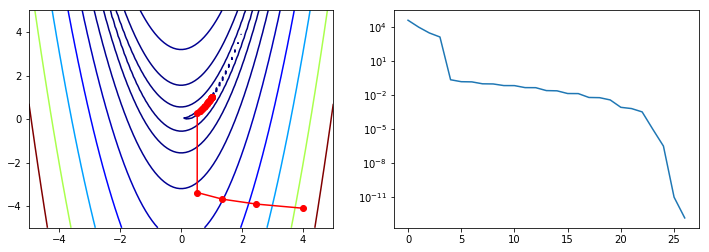

In [49]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T))
pass

#### Newton-CG

Second order methods solve for $H^{-1}$ and so require calculation of the Hessian (either provided or approximated using finite differences). For efficiency reasons, the Hessian is not directly inverted, but solved for using a variety of methods such as conjugate gradient. An example of a second order method in the `optimize` package is `Newton-GC`.

In [50]:
ps = [x0]
opt.minimize(rosen, x0, method='Newton-CG', jac=rosen_der, hess=rosen_hess, callback=reporter)

     fun: 1.3642782750354208e-13
     jac: array([ 1.21204353e-04, -6.08502470e-05])
 message: 'Optimization terminated successfully.'
    nfev: 38
    nhev: 26
     nit: 26
    njev: 63
  status: 0
 success: True
       x: array([0.99999963, 0.99999926])

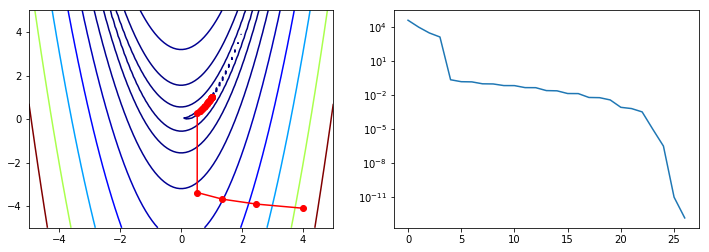

In [51]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T))
pass